In [1]:
import os
import json
import dataclasses
import torch
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import patches, ticker
import seaborn as sns
import pandas as pd

print("tiny experiments")
save_dir = './tiny_imgs/'
os.makedirs(save_dir, exist_ok=True)

tiny experiments


Theme and Utils

In [2]:
colors = sns.color_palette("Blues", 100)
color1 = colors[58]             # Blue
color2 = (0.935, 0.58, 0.)      # Orange

def draw_detached_grid(ax, nx=6, ny=6, color="lightgray", lw=1, ls="-", zorder=0):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xs = np.linspace(xlim[0], xlim[1], nx + 2)[1:-1]
    ys = np.linspace(ylim[0], ylim[1], ny + 2)[1:-1]

    for x in xs:
        ax.axvline(x, color=color, lw=lw, ls=ls, zorder=zorder)
    for y in ys:
        ax.axhline(y, color=color, lw=lw, ls=ls, zorder=zorder)

Observation 1: Top-k Parallel Decoding

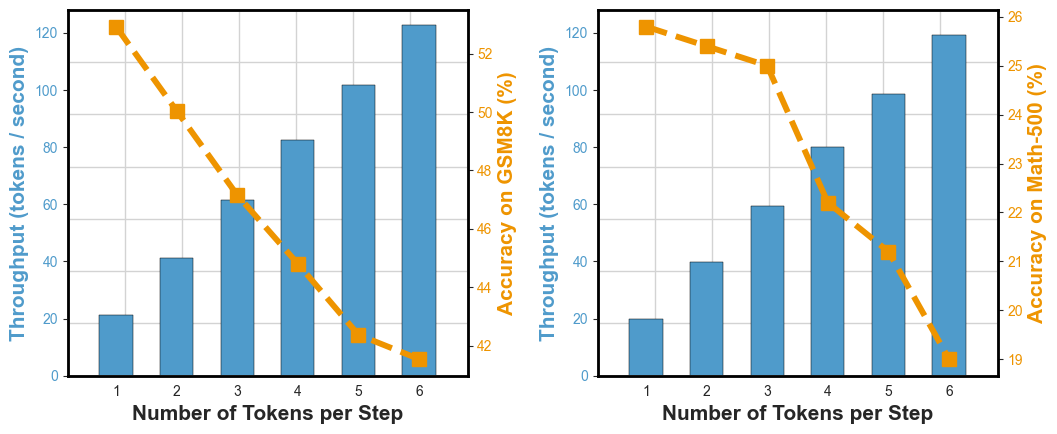

In [3]:
# plt.style.use(["science", "no-latex"])
plt.rcParams["axes.linewidth"] = 2

ks = [1, 2, 3, 4, 5, 6]

# gsm8k
score_gsm8k = [52.92, 50.04, 47.16, 44.81, 42.38, 41.55]
tps_gsm8k = [21.22, 41.33, 61.55, 82.66, 101.85, 122.87]

# math-500
score_math500 = [25.8, 25.4, 25, 22.2, 21.2, 19]
tps_math500 = [19.93, 39.83, 59.23, 79.90, 98.50, 119.10]

fig, axes = plt.subplots(1, 2, figsize=(12, 4.75))

axes[0].bar(ks, tps_gsm8k, width=0.55, color=color1, edgecolor="black", linewidth=0.35, label="Throughput")
axes[0].grid(False)
axes[0].set_xticks(list(range(1, 7)))
# axes[0].set_xticklabels([1, 2, 3, 4, 5, 6], rotation=45)
axes[0].set_ylim([0, 128])
axes[0].set_xlim([0.2, 6.8])
axes[0].set_xlabel("Number of Tokens per Step", fontsize=15, fontweight="bold")
axes[0].set_ylabel("Throughput (tokens / second)", fontsize=15, color=color1, fontweight="bold")
axes[0].tick_params(axis='y', labelcolor=color1)
axtwin0 = axes[0].twinx()
axtwin0.plot(ks, score_gsm8k, "--s", markersize=10, markerfacecolor=color2, markeredgecolor=color2, color=color2, linewidth=4.25)
axtwin0.grid(False)
axtwin0.set_ylabel("Accuracy on GSM8K (%)", fontsize=15, color=color2, fontweight="bold")
axtwin0.tick_params(axis='y', labelcolor=color2)
# axtwin.set_ylim([37, 77])

axes[1].bar(ks, tps_math500, width=0.55, color=color1, edgecolor="black", linewidth=0.35, label="Throughput")
axes[1].grid(False)
axes[1].set_xticks(list(range(1, 7)))
axes[1].set_ylim([0, 128])
axes[1].set_xlim([0.2, 6.8])
axes[1].set_xlabel("Number of Tokens per Step", fontsize=15, fontweight="bold")
axes[1].set_ylabel("Throughput (tokens / second)", fontsize=15, color=color1, fontweight="bold")
axes[1].tick_params(axis='y', labelcolor=color1)
axtwin1 = axes[1].twinx()
axtwin1.plot(ks, score_math500, "--s", markersize=10, markerfacecolor=color2, markeredgecolor=color2, color=color2, linewidth=4.25)
axtwin1.grid(False)
axtwin1.set_ylabel("Accuracy on Math-500 (%)", fontsize=15, color=color2, fontweight="bold")
axtwin1.tick_params(axis='y', labelcolor=color2)
# axtwin.set_ylim([37, 77])

draw_detached_grid(axes[0], nx=6, ny=6)
draw_detached_grid(axes[1], nx=6, ny=6)
for spine in axtwin0.spines.values():
    spine.set_color("black")
    spine.set_linewidth(2)
for spine in axtwin1.spines.values():
    spine.set_color("black")
    spine.set_linewidth(2)

fig.subplots_adjust(wspace=0.325)

fig.savefig("./tiny_imgs/parallel-decoding-observation.png", dpi=300, bbox_inches="tight")

Observation 2: Temporal Attention Map

In [5]:
from sampler.BaseSampler import GenerateOutput
from sampler.PureDLLMSampler import PureDLLMSamplerConfig, PureDLLMSampler
from visualizer import get_local
from datasets import load_dataset
import torch
import numpy as np

gen_length = 128
block_length = 128

In [ ]:
# generate files
dataset = load_dataset('openai/gsm8k', 'main')
prompts = dataset['test']['question'][0:1]

get_local.activate()
key = 'LLaDABlock._manually_scaled_dot_product_attention'
model_path = "../models/LLaDA-8B-Instruct"
config = PureDLLMSamplerConfig(
    cfg_scale=0.0,
    temperature=0.0,
    positional_weights_type='none',
    max_weight=1.0,
    initial_min_weight=0.0,
    remasking="low_confidence",
    decoding_method="topk",
    k=2
)
device="cuda:1"

sampler = PureDLLMSampler.from_path(
    model_path=model_path,
    device=device,
    config=config,
    torch_dtype=torch.bfloat16
)
tokenizer = sampler.tokenizer

get_local.cache[key] = []
for prompt in prompts:
    m = [{"role": "user", "content": prompt}]
    prompt = tokenizer.apply_chat_template(m, add_generation_prompt=True, tokenize=False)
    input_ids = tokenizer(prompt)['input_ids']
    input_ids = torch.tensor(input_ids).to(device).unsqueeze(0)
    OUT: GenerateOutput = sampler.generate(input_ids, gen_length=gen_length, max_steps=gen_length, block_length=block_length)
    actual_steps = OUT.metrics.use_steps

    value_list = get_local.cache[key]
    assert len(value_list) % actual_steps == 0
    n_layers = len(value_list) // actual_steps
    shape_per_layer = value_list[0].shape # (batch_size, heads, seq_len, seq_len)
    steps_attention_maps = np.array(value_list).reshape(
        (actual_steps, n_layers) + shape_per_layer
    ).astype(np.float16) # (steps, N_layers, batch_size, heads, seq_len, seq_len)
    np.save("data/steps_attention_maps.npy", steps_attention_maps)  #save numpy


In [31]:
from matplotlib.colors import LinearSegmentedColormap

gen_length = 128
block_length = 128

loaded_maps = np.load("data/steps_attention_maps.npy")
print("loaded shape:", loaded_maps.shape)
print("loaded type:", loaded_maps.dtype)

attn_maps_resp = loaded_maps[:, :, :, :, -gen_length:, -gen_length:]  # (steps, N_layers, batch_size, heads, gen_len, gen_len)

os.makedirs('tiny_imgs/obs2/', exist_ok=True)

nrows = 1
ncols = 6
n_plots = nrows * ncols

steps = gen_length//2
jump = 12
step_indices = [0] + list(range(jump, steps, jump))

# cmaps = ['Blues']
cmaps = ['Blues_r', 'YlGnBu_r']
# cmaps = ['YlGnBu', 'YlGnBu_r']

for cmap in cmaps:
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 7, nrows * 7), gridspec_kw={'hspace': 0.0, 'wspace': 0.05})
    axes_flat = axes.flat
    plot_count = 0

    for plot_count, (step_idx, ax) in enumerate(zip(step_indices, axes_flat), 1):
        t = gen_length//2 - 1 - step_idx
        attn_map_resp_avg = attn_maps_resp[step_idx, :, 0].mean(axis=(0, 1)) # shape: (seq, seq)
        # colors = [(0.0, 'blue'), (1.0, 'yellow')]
        # cmap = LinearSegmentedColormap.from_list('BlueYellow', colors, N=256)
        # Blue, ocean, PuBu, BuGn, GnBu
        im = ax.imshow(attn_map_resp_avg, cmap=cmap, origin="upper", vmin=0, vmax=0.1)

        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')

        ticks_labels = np.linspace(0, gen_length, 5).astype(int)
        ticks_positions = np.linspace(-0.5, gen_length - 0.5, 5)
        # ax.set_xticks([])
        # ax.set_yticks([])
        ax.set_xticks(ticks_positions)
        ax.set_yticks(ticks_positions)
        ax.set_xticklabels(ticks_labels, fontsize=15)
        ax.set_yticklabels(ticks_labels, fontsize=15)
        # ax.set_ylabel('Query (Token Index)', fontsize=15, fontweight='bold')
        # ax.tick_params(axis='x', bottom=True)
        ax.xaxis.tick_bottom()
        ax.xaxis.set_label_position('bottom')
        ax.grid(False)
        ax.set_xlabel('Key', fontsize=15, fontweight='bold')

    # for i in range(plot_count, n_plots):
    #     axes_flat[i].axis('off')

    fig.colorbar(
        im,
        ax=axes.ravel().tolist(), # 将 colorbar 关联到所有 axes
        shrink=0.7,
        pad=0.02
    )

    # fig.supylabel('Query', fontsize=15, fontweight='bold', ha='center', rotation='vertical', x=0.1125)
    fig.supylabel('Query', fontsize=15, fontweight='bold', ha='center', rotation='vertical', x=0.111)

    # draw arrow
    # bbox_first = axes_flat[0].get_position()
    # bbox_last = axes_flat[-1].get_position()
    # # arrow pos
    # x0 = bbox_first.x0 + 0.0
    # y0 = bbox_first.y1 + 0.05
    # x1 = bbox_last.x1 + 0.0
    # y1 = y0
    # mid_x = (x0 + x1) / 2
    # # draw on a top layer
    # ax_global = fig.add_axes([0, 0, 1, 1], zorder=20)
    # ax_global.axis('off')
    #
    # # draw arrow
    # ax_global.annotate(
    #     '',  # 不显示文本
    #     xy=(x1, y1),      # 结束点 (figure fraction)
    #     xytext=(x0, y0),  # 起始点 (figure fraction)
    #     xycoords='figure fraction',
    #     textcoords='figure fraction',
    #     arrowprops=dict(
    #         arrowstyle="simple,head_length=1.2,head_width=1.2,tail_width=0.3",
    #         connectionstyle="arc3",    # 直线连接
    #         color="black",
    #         linewidth=10,
    #         shrinkA=5, shrinkB=5       # 可选：从两端收缩一点点
    #     ),
    #     zorder=20
    # )
    # fig.text(
    #     (x0 + x1) / 2,
    #     y0 + 0.02,  # 文字在箭头上方
    #     "Decoding Process",
    #     ha='center',
    #     va='bottom',
    #     fontsize=24,
    #     color='black',
    #     weight='bold',
    #     transform=fig.transFigure,
    #     zorder=25
    # )

    fig.tight_layout()
    # plt.subplots_adjust(left=0.05, right=0.8, top=0.8, bottom=0.1)
    save_path = f'tiny_imgs/obs2/noarrow_all_maps_{nrows}x{ncols}_{cmap}.png'
    # save_path = f'tiny_imgs/obs2/noarrow_all_maps_{nrows}x{ncols}_{cmap}_wotick.png'
    # fig.savefig(save_path, dpi=100, bbox_inches='tight')
    plt.close()
    print(f"successfuly saved {plot_count} attention maps to {save_path}")

loaded shape: (64, 32, 1, 32, 204, 204)
loaded type: float16


/tmp/ipykernel_32728/1872529850.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


successfuly saved 6 attention maps to tiny_imgs/obs2/noarrow_all_maps_1x6_Blues_r.png
successfuly saved 6 attention maps to tiny_imgs/obs2/noarrow_all_maps_1x6_YlGnBu_r.png


/tmp/ipykernel_32728/1872529850.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Ablation: The Effect of N

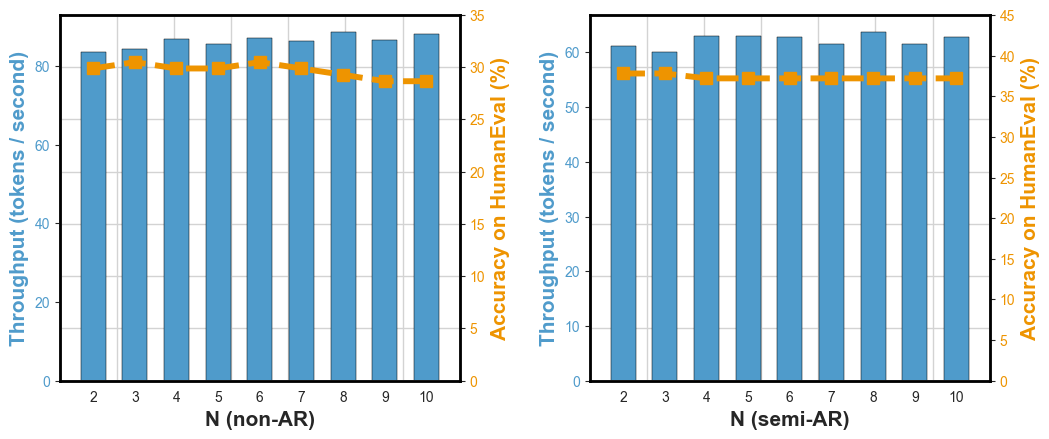

In [4]:
Ns = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=np.int32)

#non-AR
score_non = [29.88, 30.49, 29.88, 29.88, 30.49, 29.88, 29.27, 28.66, 28.66]
tps_non = [83.65, 84.42, 86.85, 85.58, 87.23, 86.27, 88.55, 86.60, 88.16]
# title = 'N_256-256_humaneval'

# semi-AR
score_semi = [37.8, 37.8, 37.2, 37.2, 37.2, 37.2, 37.2, 37.2, 37.2]
tps_semi = [61.14, 60.06, 62.94, 62.94, 62.77, 61.49, 63.64, 61.56, 62.80]
# title = 'N_128-256_humaneval'

# plt.style.use(["science", "no-latex"])

plt.rcParams["axes.linewidth"] = 2

color1 = colors[58]
color2 = (0.935, 0.58, 0.)

fig, axes = plt.subplots(1, 2, figsize=(12, 4.75))

axes[0].bar(Ns, tps_non, width=0.6, color=color1, edgecolor="black", linewidth=0.35, label="Throughput")
axes[0].grid(False)
axes[0].set_xticks(Ns)
axes[0].set_xticklabels((Ns).astype(np.int32))
axes[0].set_xlim([1.2, 10.8])
axes[0].set_xlabel("N (non-AR)", fontsize=15, fontweight="bold")
axes[0].set_ylabel("Throughput (tokens / second)", fontsize=15, color=color1, fontweight="bold")
axes[0].tick_params(axis='y', labelcolor=color1)
axtwin0 = axes[0].twinx()
axtwin0.grid(False)
axtwin0.plot(Ns, score_non, "--s", markersize=9, markerfacecolor=color2, markeredgecolor=color2, color=color2,
            linewidth=4.25)
axtwin0.set_ylabel("Accuracy on HumanEval (%)", fontsize=15, color=color2, fontweight="bold")
axtwin0.tick_params(axis='y', labelcolor=color2)
axtwin0.set_ylim(bottom=0, top=35)


axes[1].bar(Ns, tps_semi, width=0.6, color=color1, edgecolor="black", linewidth=0.35, label="Throughput")
axes[1].grid(False)
axes[1].set_xticks(Ns)
axes[1].set_xticklabels((Ns).astype(np.int32))
axes[1].set_xlim([1.2, 10.8])
axes[1].set_xlabel("N (semi-AR)", fontsize=15, fontweight="bold")
axes[1].set_ylabel("Throughput (tokens / second)", fontsize=15, color=color1, fontweight="bold")
axes[1].tick_params(axis='y', labelcolor=color1)

axtwin1 = axes[1].twinx()
axtwin1.grid(False)
axtwin1.plot(Ns, score_semi, "--s", markersize=9, markerfacecolor=color2, markeredgecolor=color2, color=color2,
            linewidth=4.25)
axtwin1.set_ylabel("Accuracy on HumanEval (%)", fontsize=15, color=color2, fontweight="bold")
axtwin1.tick_params(axis='y', labelcolor=color2)
axtwin1.set_ylim(bottom=0, top=45)

draw_detached_grid(axes[0], nx=6, ny=6, color="lightgray", lw=1, ls="-")
draw_detached_grid(axes[1], nx=6, ny=6, color="lightgray", lw=1, ls="-")
for spine in axtwin0.spines.values():
    spine.set_color("black")
    spine.set_linewidth(2)
for spine in axtwin1.spines.values():
    spine.set_color("black")
    spine.set_linewidth(2)

fig.subplots_adjust(wspace=0.325)

fig.savefig("./tiny_imgs/ablation-effect-of-N.png", dpi=300, bbox_inches="tight")

Ablation: Fixed vs Factor

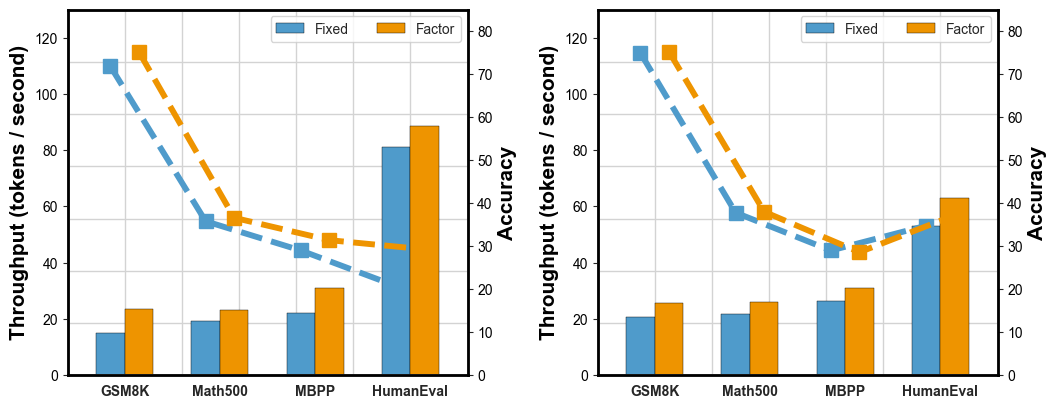

In [6]:
import matplotlib.patheffects as pe

benchmarks = ("GSM8K", "Math500", "MBPP", "HumanEval")
# non-AR
score_non = {
    'Fixed': (71.80, 35.80, 29.00, 20.73),
    'Factor': (75.13, 36.6, 31.4, 29.27),
}
tps_non = {
    'Fixed': (14.98, 19.21, 22.31, 81.09),
    'Factor': (23.46, 23.19, 31.02, 88.55),
}
# non-AR
score_semi = {
    'Fixed': (74.91, 37.80, 29.00, 34.76),
    'Factor': (75.21, 38.00, 28.60, 37.20),
}
tps_semi = {
    'Fixed': (20.73, 21.79, 26.24, 53.18),
    'Factor': (25.63, 25.89, 31.02, 62.94),
}

line_border = [pe.Stroke(linewidth=7, foreground='black'), pe.Normal()]
fig, axes = plt.subplots(1, 2, figsize=(12, 4.75))
x = np.arange(len(benchmarks))
width = 0.3
begin = -0.15
plt.rcParams["axes.linewidth"] = 2
colors_local = [color1, color2]

# plot non-AR
axes[0].grid(False)
axes[0].set_xticks(list(range(len(benchmarks))))
axes[0].set_xticklabels(benchmarks, fontweight="bold")
axes[0].set_ylim([0, 130])
axes[0].set_xlim([-0.6, len(benchmarks) - 1 + 0.6])
axes[0].set_ylabel("Throughput (tokens / second)", fontsize=15, color='black', fontweight="bold")
# axes[0].set_title('non-AR', fontsize=15, color='black', fontweight="bold")
axes[0].tick_params(axis='y', labelcolor='black')

for i, (attribute, tps) in enumerate(tps_non.items()):
    rects = axes[0].bar(x + i * width + begin, tps, width, label=attribute, color=colors_local[i], edgecolor="black", linewidth=width)
    # axes[0].bar_label(rects, padding=3)
axtwin0 = axes[0].twinx()
axtwin0.plot(x-0.15, score_non['Fixed'], "--s", markersize=10, markerfacecolor=color1, markeredgecolor=color1, color=color1, linewidth=4.25)
axtwin0.plot(x+0.15, score_non['Factor'], "--s", markersize=10, markerfacecolor=color2, markeredgecolor=color2, color=color2, linewidth=4.25)
axtwin0.grid(False)
axtwin0.set_ylim([0, 85])
axtwin0.set_ylabel("Accuracy", fontsize=15, color='black', fontweight="bold")
axtwin0.tick_params(axis='y', labelcolor='black')
axes[0].legend(loc='upper right', ncols=2)


# plot semi-AR
axes[1].grid(False)
axes[1].set_xticks(list(range(len(benchmarks))))
axes[1].set_xticklabels(benchmarks, fontweight="bold")
axes[1].set_ylim([0, 130])
axes[1].set_xlim([-0.6, len(benchmarks) - 1 + 0.6])
axes[1].set_ylabel("Throughput (tokens / second)", fontsize=15, color="black", fontweight="bold")
# axes[1].set_title('semi-AR', fontsize=15, color='black', fontweight="bold")
axes[1].tick_params(axis='y', labelcolor='black')
for i, (attribute, tps) in enumerate(tps_semi.items()):
    rects = axes[1].bar(x + i * width + begin, tps, width, label=attribute, color=colors_local[i], edgecolor="black", linewidth=width)
    # axes[1].bar_label(rects, padding=3)

axtwin1 = axes[1].twinx()
axtwin1.plot(x-0.15, score_semi['Fixed'], "--s", markersize=10, markerfacecolor=color1, color=color1, linewidth=4.25)
axtwin1.plot(x+0.15, score_semi['Factor'], "--s", markersize=10, markerfacecolor=color2, color=color2, linewidth=4.25)
axtwin1.grid(False)
axtwin1.set_ylim([0, 85])
axtwin1.set_ylabel("Accuracy", fontsize=15, color='black', fontweight="bold")
axtwin1.tick_params(axis='y', labelcolor='black')
axes[1].legend(loc='upper right', ncols=2)

draw_detached_grid(axes[0], nx=6, ny=6)
draw_detached_grid(axes[1], nx=6, ny=6)
for spine in axtwin0.spines.values():
    spine.set_color("black")
    spine.set_linewidth(2)
for spine in axtwin1.spines.values():
    spine.set_color("black")
    spine.set_linewidth(2)

fig.subplots_adjust(wspace=0.325)

fig.savefig("./tiny_imgs/fixed-vs-factor-ablation.png", dpi=300, bbox_inches="tight")
# plt.close()

Ablation: Decoding Trajectory (Fast-dllm vs. DiCo+TG)

In [7]:
def json_converter(obj):
    if isinstance(obj, torch.Tensor):
        return obj.tolist()
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

In [ ]:
device = 'cuda:0'
model_path = "../models/LLaDA-8B-Instruct"

gsm8k_dataset = load_dataset('openai/gsm8k', 'main')
prompts = gsm8k_dataset['test']['question'][0:10]

# use llada
model_path = "../models/LLaDA-8B-Instruct"
token_info = {
    'mask_id': 126336,
    'bos_id': 126080,
    'pad_id': 126081,
    'eos_id': 126081,
    'eot_id': 126348
}

# use dream
# model_path = "../models/Dream-7B-Instruct"
# token_info = {
#     'mask_id': 151666,
#     'bos_id': 151665,
#     'pad_id': 151643,
#     'eos_id': 151643,
#     'eot_id': 151643
# }

config = PureDLLMSamplerConfig(
    cfg_scale=0.0,
    temperature=0.0,
    positional_weights_type='none',
    max_weight=1.0,
    initial_min_weight=0.05,
    remasking="low_confidence",
    decoding_method="topk",
    factor=1,
    k=1,
    confidence_threshold=0.9,
    **token_info
)

max_gen_steps = 256
block_length = 256
sampler = PureDLLMSampler.from_path(
    model_path=model_path,
    device=device,
    config=config,
    torch_dtype=torch.bfloat16
)

pmp_idx = 8
tokenizer = sampler.tokenizer
prompt_text = prompts[pmp_idx]
m = [{"role": "user", "content": prompt_text}]
prompt_str = tokenizer.apply_chat_template(m, add_generation_prompt=True, tokenize=False)
input_ids = tokenizer(prompt_str, return_tensors="pt").input_ids.to(device)
OUT = sampler.generate(input_ids, gen_length=max_gen_steps, max_steps=max_gen_steps, block_length=block_length)
out_dict = dataclasses.asdict(OUT)
output_filename = f"data/pure_llada_decoding_trajectory_pmp{pmp_idx}.json"
with open(output_filename, "w") as f:
    json.dump(
        out_dict,
        f,
        indent=2,
        default=json_converter  # [!] important
    )


Ploting Decoding Trajectory

In [8]:
# original plot
def plot_trajectory(confidences, transfer_idxs, save_path, title_text, title_size=120):

    num_steps = len(confidences)
    seq_len = len(confidences[0])

    fig, ax = plt.subplots(figsize=(32, num_steps/seq_len*32))

    im = ax.imshow(confidences, cmap='Blues', interpolation='nearest', vmin=0, vmax=1, aspect='auto')

    ax.text(
        0.5,  # X 坐标 (0.5 = 图像宽度的 50% = 中心)
        0.7,  # Y 坐标 (0.5 = 图像高度的 50% = 中心)
        title_text,
        transform=ax.transAxes, # 确保坐标是相对于图像区域 (0,0)到(1,1)
        fontsize=title_size,          # 字体大一些 (根据需要调整)
        color='black',        # 字体颜色 (白色或黑色通常效果较好)
        alpha=0.4,            # 半透明 (0.0 到 1.0 之间)
        ha='center',          # 水平居中
        va='center'           # 垂直居中
    )
    for i in range(num_steps):
        for j in range(seq_len):
            if transfer_idxs[i][j]:
                rect = patches.Rectangle(
                    (j - 0.5, i - 0.5),
                    1, 1,
                    linewidth=5,          # 设置边框线宽
                    edgecolor='red',      # 设置边框颜色为红色
                    facecolor='none'      # 设置填充色为无，只保留边框
                )
                ax.add_patch(rect)

    ax.axis('off')
    # ax.set_xlabel("seq_len", fontsize=fontsize)
    # ax.set_ylabel("step", fontsize=fontsize)

    # ax.set_xticks([0, seq_len-1])
    # ax.set_yticks([0, seq_len-1])
    # ax.set_xticklabels([1, seq_len])
    # ax.set_yticklabels([1, seq_len])
    # ax.tick_params(axis='both', which='major', labelsize=fontsize)

    fig.tight_layout()

    plt.savefig(save_path, dpi=150)
    plt.close()

# seaborn plot
def plot_trajectory_bubble(confidences, transfer_idxs, save_path, title_text, title_size=120):

    # list -> numpy
    confidences = np.array(confidences)
    confidences = np.nan_to_num(confidences, 0.0).astype(np.float32)
    transfer_idxs = np.array(transfer_idxs).astype(bool)
    num_steps, seq_len = confidences.shape

    # gird for Y and X
    steps_idx, seq_idx = np.indices((num_steps, seq_len))

    # numpy -> pd
    df = pd.DataFrame({
        'step': steps_idx.ravel(),
        'seq_idx': seq_idx.ravel(),
        'confidence': confidences.ravel(),
        'highlight': transfer_idxs.ravel()
    })

    sns.set_theme(style="whitegrid",
                  rc={"grid.linewidth": 1.25}
    )

    aspect_ratio = seq_len / num_steps
    plot_height = 18

    bubble_size = 10
    g = sns.relplot(
        data=df,
        x='seq_idx',
        y='step',
        hue='confidence',      # conf -> 颜色
        palette='Blues',       # 保持蓝色系
        hue_norm=(0, 1),       # 颜色范围
        size_norm=(0, 1),      # 尺寸范围
        s=bubble_size,
        height=plot_height,        # 图像高度
        aspect=aspect_ratio*1.2,       # 图像宽高比
        kind="scatter",
        legend=False,
    )

    df_highlight = df[df['highlight']]
    ax = g.ax
    if not df_highlight.empty:
        sns.scatterplot(
            data=df_highlight,
            x='seq_idx', y='step',
            s=bubble_size*1.2,      # 大小与 conf 点一致
            color='red',       # 颜色固定为红色
            ax=ax,
            legend=False,      # 不需要图例
            zorder=5           # 确保覆盖在蓝点之上
        )

    norm = plt.Normalize(vmin=0, vmax=1)
    cmap = plt.get_cmap('Blues')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = g.fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02, shrink=0.98, aspect=40)
    cbar.set_label('Confidence', rotation=-90, va="bottom", labelpad=15, fontsize=30)

    # fine-tune
    # g.set(xlabel="Sequence", ylabel="Decoding Process", fontsize=24)
    ax.set_xlabel("Sequence", fontsize=30)
    ax.set_ylabel("Decoding Process", fontsize=30)

    ax.margins(0, 0)
    g.despine(top=True)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)

    tick_spacing = 32
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    ax.grid(which='minor', linestyle=':', linewidth=0.3, alpha=1.0)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))

    ax.set_xlim(-1.1, 256.1)
    ax.set_ylim(-1.1, 256.1)
    ax.invert_yaxis()

    # save
    g.savefig(save_path, dpi=200)
    plt.close(g.fig)

    print(f"trajectory bubble saved to: {save_path}")

# seaborn in ax -> use this
def plot_trajectory_bubble_on_axe(
    ax,
    confidences,
    transfer_idxs,
    bubble_size=1.25,
    max_gen_len=256
):
    assert max_gen_len >= len(confidences)

    tick_spacing=max_gen_len//7
    # list -> numpy
    confidences = np.array(confidences)
    confidences = np.nan_to_num(confidences, 0.0).astype(np.float32)
    transfer_idxs = np.array(transfer_idxs).astype(bool)
    # flat
    confidences_mgl = np.zeros((max_gen_len, max_gen_len), dtype=np.float32)
    confidences_mgl[:len(confidences)] = confidences
    transfer_idxs_mgl = np.zeros((max_gen_len, max_gen_len), dtype=bool)
    transfer_idxs_mgl[:len(transfer_idxs)] = transfer_idxs
    # gird for Y and X
    # steps_idx, seq_idx = np.indices((num_steps, seq_len))
    steps_idx, seq_idx = np.indices((max_gen_len, max_gen_len))

    # numpy -> pd
    df = pd.DataFrame({
        'step': steps_idx.ravel(),
        'seq_idx': seq_idx.ravel(),
        'confidence': confidences_mgl.ravel(),
        'highlight': transfer_idxs_mgl.ravel() # 压平布尔值
    })

    # highlight for unmasked tokens
    df_highlight = df[df['highlight']]
    if not df_highlight.empty:
        sns.scatterplot(
            data=df_highlight,
            x='seq_idx', y='step',
            s=bubble_size*1.2,
            color='red',
            ax=ax,
            legend=False,
            zorder=5
        )

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)

    # (Major Grid)
    # ax.grid(which='major', linestyle='-', linewidth=0.5, alpha=1.0, color='grey')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    # (Minor Grid)
    # ax.grid(which='minor', linestyle='-', linewidth=0.25, alpha=1.0, color='grey')
    # ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    # ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.grid(False)

    sns.scatterplot(
        data=df,
        x='seq_idx',
        y='step',
        hue='confidence',      # conf -> 颜色
        palette='Blues',       # 保持蓝色系
        hue_norm=(0, 1),       # 颜色范围
        s=bubble_size,         # 气泡大小
        ax=ax,                 # <--- 指定在哪个 ax 上绘制
        legend=False,
        alpha=1.0
    )

    ax.set_xlabel(None)
    ax.set_ylabel(None)

    # strength
    # ax.set_xlim(-1.1, seq_len + 0.1)
    # ax.set_ylim(-1.1, num_steps + 0.1)
    # no strength
    ax.set_xlim(-1.1, confidences_mgl.shape[0] + 0.1)
    ax.set_ylim(-1.1, confidences_mgl.shape[1] + 0.1)
    ax.invert_yaxis()

print('updated')

updated


Plot Pure LLaDA Decoding Trajectory

Original Trajectory (Dumped)

In [ ]:
pmp_idx = 6
output_filename = f"data/pure_llada_decoding_trajectory_pmp{pmp_idx}.json"

with open(output_filename, "r") as f:
    data = json.load(f)

confidences = data['confidences']
transfer_idxs = data['transfer_idxs']

print(len(confidences), len(confidences[0]))
print(len(transfer_idxs), len(transfer_idxs[0]))
# plot_trajectory(confidences, transfer_idxs, f"tiny_imgs/llada_decoding_trajectory_pmp{pmp_idx}.png", "Vanilla", title_size=150)
plot_trajectory_bubble(confidences, transfer_idxs, f"tiny_imgs/llada_decoding_trajectory_bubble_pmp{pmp_idx}.png", "Vanilla", title_size=150)

Mentor's Demand: all plot in python ->_<-

In [9]:
sns.set_theme(style="white")

pmp_idxs = [2, 6]
fig, axes = plt.subplots(figsize=(12, 5), nrows=1, ncols=3, gridspec_kw={'width_ratios': [1, 1, 0.05]})
fz = 15

# BUG!!
# gs_main = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.1, figure=fig)
# gs_trs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_main[0, 0], wspace=0.3)
# axes = [
#     fig.add_subplot(gs_trs[0, 0]), # axes[0]
#     fig.add_subplot(gs_trs[0, 1])  # axes[1]
# ]
# ax_c = fig.add_subplot(gs_main[1])

for i, pmp_idx in enumerate(pmp_idxs):
    output_filename = f"data/pure_llada_decoding_trajectory_pmp{pmp_idx}.json"
    with open(output_filename, "r") as f:
        data = json.load(f)
    confidences = data['confidences']
    transfer_idxs = data['transfer_idxs']

    plot_trajectory_bubble_on_axe(
        axes[i],
        confidences,
        transfer_idxs,
    )
    axes[i].set_xlabel("Token Index", fontsize=fz, fontweight="bold", color='black')
    axes[i].set_ylabel(None)
    # axes[i].set_ylabel("Decoding Process", fontsize=fz, fontweight="bold", color='black')
    # axes[i].set_aspect('equal')

# coloarbar
ax_c = axes[2]
norm = plt.Normalize(vmin=0, vmax=1)
cmap = plt.get_cmap('Blues')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=ax_c, shrink=0.9)
cbar.set_label('Confidence', rotation=-90, va="bottom", fontsize=fz, fontweight="bold", color='black')

fig.supylabel("Decoding Process", fontsize=fz, x=0.03, fontweight="bold", ha='center', rotation='vertical')
# fig.supxlabel("Token Index in the Sequence", fontsize=fz, x=(axes[0].get_position().x0+axes[1].get_position().x1)/2, y=0.03, fontweight="bold", color='black', ha='center')

draw_detached_grid(axes[0], nx=6, ny=6, zorder=10)
draw_detached_grid(axes[1], nx=6, ny=6, zorder=10)

# fig.tight_layout()
# fig.subplots_adjust(wspace=0.325)
fig.subplots_adjust(
    left=0.08,
    right=0.92,
    top=0.95,
    bottom=0.12,
    wspace=0.25
)

save_path = f"tiny_imgs/llada_decoding_trajectory_bubble.png"
fig.savefig(save_path, dpi=300)
plt.close(fig)

print(f"combined trajectory svaed to: {save_path}")

C:\Users\lenovo\AppData\Local\Temp\ipykernel_3904\2854659314.py:156: RuntimeWarning: overflow encountered in cast
  confidences = np.nan_to_num(confidences, 0.0).astype(np.float32)
D:\Environment\Miniconda3\envs\transformer\Lib\site-packages\matplotlib\colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
D:\Environment\Miniconda3\envs\transformer\Lib\site-packages\matplotlib\colors.py:2295: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_3904\2854659314.py:156: RuntimeWarning: overflow encountered in cast
  confidences = np.nan_to_num(confidences, 0.0).astype(np.float32)
D:\Environment\Miniconda3\envs\transformer\Lib\site-packages\matplotlib\colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
D:\Environment\Miniconda3\envs\transformer\Lib\site-packages\matplotlib\colors.py:2295: RuntimeWarning: invalid value encountered in divide
  resdat /= (v

combined trajectory svaed to: tiny_imgs/llada_decoding_trajectory_bubble.png


Plot Fast-dLLM decoding trajectorym

In [ ]:
device = 'cuda:1'

# base gsm8k prompt
gsm8k_dataset = load_dataset('openai/gsm8k', 'main')
prompts = gsm8k_dataset['test']['question'][0:3]

# llada token info
model_path = "../models/LLaDA-8B-Instruct"
token_info = {
    'mask_id': 126336,
    'bos_id': 126080,
    'pad_id': 126081,
    'eos_id': 126081,
    'eot_id': 126348
}

# dream token info
# model_path = "../models/Dream-7B-Instruct"
# token_info = {
#     'mask_id': 151666,
#     'bos_id': 151665,
#     'pad_id': 151643,
#     'eos_id': 151643,
#     'eot_id': 151643
# }

config = PureDLLMSamplerConfig(
    cfg_scale=0.0,
    temperature=0.0,
    positional_weights_type='none',
    max_weight=1.0,
    initial_min_weight=0.05,
    remasking="low_confidence",
    decoding_method="fixed",
    factor=1,
    k=1,
    confidence_threshold=0.9,
    **token_info
)

max_gen_steps = 256
block_length = 256
sampler = PureDLLMSampler.from_path(
    model_path=model_path,
    device=device,
    config=config,
    torch_dtype=torch.bfloat16
)

pmp_idx = 2
tokenizer = sampler.tokenizer
prompt_text = prompts[pmp_idx]
m = [{"role": "user", "content": prompt_text}]
prompt_str = tokenizer.apply_chat_template(m, add_generation_prompt=True, tokenize=False)
input_ids = tokenizer(prompt_str, return_tensors="pt").input_ids.to(device)
OUT = sampler.generate(input_ids, gen_length=max_gen_steps, max_steps=max_gen_steps, block_length=block_length)
out_dict = dataclasses.asdict(OUT)
output_filename = f"data/fastdllm_decoding_trajectory_pmp{pmp_idx}.json"
with open(output_filename, "w") as f:
    json.dump(
        out_dict,
        f,
        indent=2,
        default=json_converter
    )


In [ ]:
pmp_idx = 2
output_filename = f"data/fastdllm_decoding_trajectory_pmp{pmp_idx}.json"

with open(output_filename, "r") as f:
    data = json.load(f)

confidences = data['confidences']
transfer_idxs = data['transfer_idxs']

print(len(confidences), len(confidences[0]))
print(len(transfer_idxs), len(transfer_idxs[0]))
plot_trajectory(confidences, transfer_idxs, f"tiny_imgs/fastdllm_decoding_trajectory_pmp{pmp_idx}.png", "Fast-dLLM", title_size=120)

Plot DiCo Decoding Trajectory

In [ ]:
# generate files
%%capture
from sampler.DiCoSampler import DiCoSamplerConfig, DiCoSampler

device = 'cuda:1'

# base gsm8k prompt
gsm8k_dataset = load_dataset('openai/gsm8k', 'main')
prompts = gsm8k_dataset['test']['question'][0:3]

# llada token info
model_path = "../models/LLaDA-8B-Instruct"
token_info = {
    'mask_id': 126336,
    'bos_id': 126080,
    'pad_id': 126081,
    'eos_id': 126081,
    'eot_id': 126348
}

# dream token info
# model_path = "../models/Dream-7B-Instruct"
# token_info = {
#     'mask_id': 151666,
#     'bos_id': 151665,
#     'pad_id': 151643,
#     'eos_id': 151643,
#     'eot_id': 151643
# }

config = DiCoSamplerConfig(
    **token_info,
    cfg_scale=0.0,
    temperature=0.0,
    max_exploration_steps=5,
    exploration_N=8,
    exploration_M=2,
    exploration_threshold=0.3,
    acceleration_parallel_method='factor',
    acceleration_threshold=0.9,
    acceleration_low_threshold=0.6,
    acceleration_factor=1,
    mopup_gate_ratio=0.8,
    mopup_margin_threshold=3,
    mopup_speed=1,
    positional_weights_type='ratio',
    max_weight=1.0,
    initial_min_weight=0.05,
    ur_factor=0.5
)

sampler = DiCoSampler.from_path(
    model_path=model_path,
    device=device,
    config=config,
    torch_dtype=torch.bfloat16
)

max_steps = 256
block_length = 256

tokenizer = sampler.tokenizer
pmp_idx = 2
prompt_text = prompts[pmp_idx]
m = [{"role": "user", "content": prompt_text}]
prompt_str = tokenizer.apply_chat_template(m, add_generation_prompt=True, tokenize=False)
input_ids = tokenizer(prompt_str, return_tensors="pt").input_ids.to(device)
OUT = sampler.generate(input_ids, gen_length=max_steps, max_steps=max_steps, block_length=block_length)
out_dict = dataclasses.asdict(OUT)

output_filename = f"data/dico_decoding_trajectory_PWT{sampler.positional_weights_type}_pmp{pmp_idx}.json"
with open(output_filename, "w") as f:
    json.dump(
        out_dict,
        f,
        indent=2,
        default=json_converter
    )


Ablation(dumped): Fast-dllm vs. DiCo+TG

In [10]:
sns.set_theme(style="white")

pmp_idx = 2
fig, axes = plt.subplots(figsize=(12, 5), nrows=1, ncols=3, gridspec_kw={'width_ratios': [1, 1, 0.05]})
fz = 15

# Fast-dllm
output_filename = f"data/fastdllm_decoding_trajectory_pmp{pmp_idx}.json"
with open(output_filename, "r") as f:
    data = json.load(f)
confidences = data['confidences']
transfer_idxs = data['transfer_idxs']
plot_trajectory_bubble_on_axe(
    axes[0],
    confidences,
    transfer_idxs,
    max_gen_len=256
)
axes[0].set_xlabel("Token Index", fontsize=fz, fontweight="bold", color='black')
axes[0].set_title("Fast-dllm", fontsize=fz, fontweight="bold", color='black')
# axes[0].set_ylabel("Fast-dllm")
# axes[i].set_ylabel("Decoding Process", fontsize=fz, fontweight="bold", color='black')
# axes[i].set_aspect('equal')

# DiCo+TG
output_filename = f"data/dico_decoding_trajectory_PWTratio_pmp{pmp_idx}.json"
with open(output_filename, "r") as f:
    data = json.load(f)
confidences = data['confidences']
transfer_idxs = data['transfer_idxs']
plot_trajectory_bubble_on_axe(
    axes[1],
    confidences,
    transfer_idxs,
    max_gen_len=256
)
axes[1].set_xlabel("Token Index", fontsize=fz, fontweight="bold", color='black')
axes[1].set_title("DiCo+TG", fontsize=fz, fontweight="bold", color='black')
# axes[1].set_ylabel("DiCo")
# axes[i].set_ylabel("Decoding Process", fontsize=fz, fontweight="bold", color='black')
# axes[i].set_aspect('equal')

# coloarbar
ax_c = axes[2]
norm = plt.Normalize(vmin=0, vmax=1)
cmap = plt.get_cmap('Blues')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=ax_c, shrink=0.9)
cbar.set_label('Confidence', rotation=-90, va="bottom", fontsize=fz, fontweight="bold", color='black')

fig.supylabel("Decoding Process", fontsize=fz, x=0.03, fontweight="bold", ha='center', rotation='vertical')
# fig.supxlabel("Token Index in the Sequence", fontsize=fz, x=(axes[0].get_position().x0+axes[1].get_position().x1)/2, y=0.03, fontweight="bold", color='black', ha='center')

draw_detached_grid(axes[0], nx=6, ny=6, zorder=10)
draw_detached_grid(axes[1], nx=6, ny=6, zorder=10)

# fig.tight_layout()
# fig.subplots_adjust(wspace=0.325)
fig.subplots_adjust(
    left=0.08,
    right=0.92,
    top=0.92,
    bottom=0.12,
    wspace=0.25
)

save_path = f"tiny_imgs/fastdllm_vs_dico_tg_trajectories_bubble.png"
fig.savefig(save_path, dpi=300)
plt.close(fig)

print(f"combined trajectory svaed to: {save_path}")

C:\Users\lenovo\AppData\Local\Temp\ipykernel_3904\2854659314.py:156: RuntimeWarning: overflow encountered in cast
  confidences = np.nan_to_num(confidences, 0.0).astype(np.float32)
D:\Environment\Miniconda3\envs\transformer\Lib\site-packages\matplotlib\colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
D:\Environment\Miniconda3\envs\transformer\Lib\site-packages\matplotlib\colors.py:2295: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_3904\2854659314.py:156: RuntimeWarning: overflow encountered in cast
  confidences = np.nan_to_num(confidences, 0.0).astype(np.float32)
D:\Environment\Miniconda3\envs\transformer\Lib\site-packages\matplotlib\colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
D:\Environment\Miniconda3\envs\transformer\Lib\site-packages\matplotlib\colors.py:2295: RuntimeWarning: invalid value encountered in divide
  resdat /= (v

combined trajectory svaed to: tiny_imgs/fastdllm_vs_dico_tg_trajectories_bubble.png


Ablation: DiCo vs. DiCo+TG

In [ ]:
sns.set_theme(style="white")

pmp_idx = 2
fig, axes = plt.subplots(figsize=(12, 5), nrows=1, ncols=3, gridspec_kw={'width_ratios': [1, 1, 0.05]})
fz = 15

# DiCo w/o TG
output_filename = f"data/dico_decoding_trajectory_PWTnone_pmp{pmp_idx}.json"
with open(output_filename, "r") as f:
    data = json.load(f)
confidences = data['confidences']
transfer_idxs = data['transfer_idxs']
plot_trajectory_bubble_on_axe(
    axes[0],
    confidences,
    transfer_idxs,
    max_gen_len=256
)
axes[0].set_xlabel("Token Index", fontsize=fz, fontweight="bold", color='black')
# axes[0].set_title("DiCo w/o TG", fontsize=fz, fontweight="bold", color='black')
# axes[0].set_ylabel("DiCo w/o TG")
# axes[i].set_ylabel("Decoding Process", fontsize=fz, fontweight="bold", color='black')
# axes[i].set_aspect('equal')

# DiCo w/o TG
output_filename = f"data/dico_decoding_trajectory_PWTratio_pmp{pmp_idx}.json"
with open(output_filename, "r") as f:
    data = json.load(f)
confidences = data['confidences']
transfer_idxs = data['transfer_idxs']
plot_trajectory_bubble_on_axe(
    axes[1],
    confidences,
    transfer_idxs,
    max_gen_len=256
)
axes[1].set_xlabel("Token Index", fontsize=fz, fontweight="bold", color='black')
# axes[1].set_title("DiCo w/ TG", fontsize=fz, fontweight="bold", color='black')
# axes[1].set_ylabel("DiCo")
# axes[i].set_ylabel("Decoding Process", fontsize=fz, fontweight="bold", color='black')
# axes[i].set_aspect('equal')

# coloarbar
ax_c = axes[2]
norm = plt.Normalize(vmin=0, vmax=1)
cmap = plt.get_cmap('Blues')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=ax_c, shrink=0.9)
cbar.set_label('Confidence', rotation=-90, va="bottom", fontsize=fz, fontweight="bold", color='black')

fig.supylabel("Decoding Process", fontsize=fz, x=0.03, fontweight="bold", ha='center', rotation='vertical')
# fig.supxlabel("Token Index in the Sequence", fontsize=fz, x=(axes[0].get_position().x0+axes[1].get_position().x1)/2, y=0.03, fontweight="bold", color='black', ha='center')

draw_detached_grid(axes[0], nx=6, ny=6, zorder=10)
draw_detached_grid(axes[1], nx=6, ny=6, zorder=10)

fig.tight_layout()
# fig.subplots_adjust(wspace=0.325)
fig.subplots_adjust(
    left=0.08,
    right=0.92,
    top=0.92,
    bottom=0.12,
    wspace=0.25
)

save_path = f"tiny_imgs/dico_vs_dico_tg_trajectories_bubble.png"
fig.savefig(save_path, dpi=300)
plt.close(fig)

print(f"combined trajectory svaed to: {save_path}")